In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D
%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def map_to_unit_cube(param_vec, param_limits):
    """
    Map a parameter vector to the unit cube from the original dimensions of the space.
    Arguments:
    param_vec - the vector of parameters to map.
    param_limits - the limits of the allowed parameters.
    Returns:
    vector of parameters, all in [0,1].
    """
    assert (np.size(param_vec),2) == np.shape(param_limits)
    assert np.all(param_vec-1e-16 <= param_limits[:,1])
    assert np.all(param_vec+1e-16 >= param_limits[:,0])
    ii = np.where(param_vec > param_limits[:,1])
    param_vec[ii] = param_limits[ii,1]
    ii = np.where(param_vec < param_limits[:,0])
    param_vec[ii] = param_limits[ii,0]
    assert np.all(param_limits[:,0] <= param_limits[:,1])
    new_params = (param_vec-param_limits[:,0])/(param_limits[:,1] - param_limits[:,0])
    assert np.all((new_params >= 0)*(new_params <= 1))
    return new_params

def map_to_unit_cube_list(param_vec_list, param_limits):
    """Map multiple parameter vectors to the unit cube"""
    return np.array([map_to_unit_cube(param_vec, param_limits) for param_vec in param_vec_list])

def input_normalize(
    params: np.ndarray, param_limits: np.ndarray
) -> np.ndarray:
    """
    Map the parameters onto a unit cube so that all the variations are
    similar in magnitude.
    
    :param params: (n_points, n_dims) parameter vectors
    :param param_limits: (n_dim, 2) param_limits is a list 
        of parameter limits.
    :return: params_cube, (n_points, n_dims) parameter vectors 
        in a unit cube.
    """
    nparams = np.shape(params)[1]
    params_cube = map_to_unit_cube_list(params, param_limits)
    assert params_cube.shape[1] == nparams

    return params_cube


In [3]:
kf = np.loadtxt("../data/360_res128box256_9_res512box256_z0/kf.txt")
X = np.loadtxt("../data/360_res128box256_9_res512box256_z0/train_input_fidelity_0.txt")
Y = np.loadtxt("../data/360_res128box256_9_res512box256_z0/train_output_fidelity_0.txt")
param_limits = np.loadtxt("../data/360_res128box256_9_res512box256_z0/input_limits.txt")

In [4]:
# Normalize input to a [0 - 1] Latin Hypercube
# This is to avoid the lengthscale & amplitude prior
# to hard to define
X = input_normalize(X, param_limits=param_limits)

In [5]:
# Normalized
Y_mean = Y.mean(axis=0)
_Y_old = Y
Y = (Y - Y_mean)

Y = Y.T

# keep 10 samples for testing
X_test = X[:50, :]
Y_test = Y[:, :50]

X = X[50:, :]
Y = Y[:, 50:]

In [6]:
X.shape, Y.shape

((310, 5), (96, 310))

## Build your GP with tensorflow

In [7]:
class InputTransformedKernel(tfk.PositiveSemidefiniteKernel):

  def __init__(self, kernel, transformation, name='InputTransformedKernel'):
    self._kernel = kernel
    self._transformation = transformation
    super(InputTransformedKernel, self).__init__(
        feature_ndims=kernel.feature_ndims,
        dtype=kernel.dtype,
        name=name)

  def apply(self, x1, x2):
    return self._kernel.apply(
        self._transformation(x1),
        self._transformation(x2))

  def matrix(self, x1, x2):
    return self._kernel.matrix(
        self._transformation(x1),
        self._transformation(x2))

  @property
  def batch_shape(self):
    return self._kernel.batch_shape

  def batch_shape_tensor(self):
    return self._kernel.batch_shape_tensor

class InputScaledKernel(InputTransformedKernel):

  def __init__(self, kernel, length_scales):
    super(InputScaledKernel, self).__init__(
        kernel,
        lambda x: x / tf.expand_dims(length_scales,
                                     -(kernel.feature_ndims + 1)))


In [8]:
num_examples, num_features = X.shape
num_outputs, num_examples  = Y.shape

def build_gp(amplitude, length_scales, 
        # observation_noise_variance
    ):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""

    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    se_kernel = tfk.ExponentiatedQuadratic(
        amplitude, #length_scale, # feature_ndims=ndim
    )
    kernel = InputScaledKernel(se_kernel, length_scales = length_scales)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=X,
        # observation_noise_variance=observation_noise_variance
    )

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude':
        tfd.LogNormal(
            loc=np.ones([num_outputs]) * 0,
            scale=np.ones([num_outputs]) * 0.5              # roughly move lengthscale to center around 1
    ),
    'length_scales':
        tfd.Independent(tfd.LogNormal(
            loc=np.ones([num_outputs, num_features]),
            scale=np.ones([num_outputs, num_features]),     # roughly move lengthscale to center around 1
    ), reinterpreted_batch_ndims=1),
    # 'observation_noise_variance':
    #     tfd.LogNormal(
    #         loc=np.ones([num_outputs]) * 0.,
    #         scale=np.ones([num_outputs])
    # ),
    'observations': build_gp,
})

# # join multiple independent GPs to one meta-GP
# meta_gp_joint_model = tfp.distributions.Independent(
#     distribution=gp_joint_model, reinterpreted_batch_ndims=1
# )

In [9]:
gp_joint_model.batch_shape

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
Instructions for updating:
`always_yield_multivariate_normal` is deprecated. After 2023-02-15, this arg will be ignored, and behavior will be as though `always_yield_multivariate_normal=True`. This means that a`GaussianProcessRegressionModel` evaluated at a single index point will have event shape `[1]`. To reproduce the behavior of `always_yield_multivariate_normal=False` squeeze the rightmost singleton dimension from the output of `mean`, `sample`, etc.


/Users/jibanmac/Documents/conda/tensorflow/lib/python3.9/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:501: FutureWarning: When the `always_yield_multivariate_normal` arg to `GaussianProcess.__init__` is ignored, after 2023-02-15, `get_marginal_distribution` will always return a Normal distribution with vector event shape. This is the current behavior when `always_yield_multivariate_normal=True`. To recover the behavior of `always_yield_multivariate_normal=False` when `index_points` contains a single index point, build a scalar `Normal` distribution as follows: `mvn = get_marginal_distribution(index_points); ``norm = tfd.Normal(mvn.loc[..., 0], scale=mvn.stddev()[..., 0])`. To suppress these warnings, build the `GaussianProcess` with `always_yield_multivariate_normal=True`.
  warnings.warn(


{'length_scales': TensorShape([96]),
 'amplitude': TensorShape([96]),
 'observations': TensorShape([96])}

In [10]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp.shape))

join_log_likelihood = tf.reduce_sum(lp)
print("Joint log likelihood {}".format(join_log_likelihood))

sampled {'length_scales': <tf.Tensor: shape=(96, 5), dtype=float64, numpy=
array([[ 1.65365069,  1.0094014 ,  2.74092348, 16.40675332,  1.22952747],
       [ 1.83085404,  1.36828194, 18.46834779,  1.27313713,  3.2087238 ],
       [ 5.23191357,  0.25003847,  0.21417728,  1.76688205,  2.72886715],
       [ 2.01518076,  5.35708501,  0.46700308,  4.62763982,  2.80394993],
       [ 2.89409611,  4.36973582,  0.49848377,  2.7909262 ,  1.79910951],
       [11.82040299,  4.34988371,  1.49355162,  0.26021708,  4.73872788],
       [ 3.4294054 , 19.03997931,  0.99625123,  0.3609453 ,  1.44900692],
       [ 5.56797848,  5.0115697 ,  0.48729051,  0.8837339 ,  4.09897133],
       [ 9.55582527,  1.58590252,  3.40511437,  2.59793778,  0.65996427],
       [ 0.93834154,  3.57193041,  5.58303326,  0.19478086,  2.66416986],
       [ 1.65383688,  6.77835054,  3.40747628,  0.42897753,  3.12967611],
       [ 1.09789011,  1.35556585,  2.57914911,  1.07209351,  1.66691372],
       [ 5.35832446,  0.08223371,  5.

## Optimize

In [11]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs]),
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs, num_features]),
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

# observation_noise_variance_var = tfp.util.TransformedVariable(
#     initial_value=np.ones([num_outputs]),
#     bijector=constrain_positive,
#     name='observation_noise_variance_var',
#     dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                    #    observation_noise_variance_var
                    ]]

In [12]:
def target_log_prob(
    amplitude,
    length_scale,
    # observation_noise_variance
  ):
  lp =  gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scales': length_scale,
    #   'observation_noise_variance': observation_noise_variance,
      'observations': Y
  })

  join_log_likelihood = tf.reduce_sum(lp)

  return join_log_likelihood

In [13]:
# Now we optimize the model parameters.
num_iters = 3000
optimizer = tf.optimizers.Adam(learning_rate=5e-3)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            # observation_noise_variance_var
                            )
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
# print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

2022-12-22 18:20:19.304387: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Trained parameters:
amplitude: [0.52777908 0.75947735 0.89400973 0.85044226 0.84400738 0.85434742
 0.91200987 0.98007439 1.00837093 1.00159204 1.00446492 0.97692692
 1.04671434 1.06135284 1.15359921 1.14466648 1.11975707 1.17138791
 1.20267907 1.15026937 1.15236766 1.18807773 1.16933416 1.14570548
 1.12816846 1.15605982 1.18764426 1.0606733  1.13655743 1.14650511
 1.11822342 1.06711004 0.99458458 1.0760351  0.90112052 0.86420509
 0.8001071  0.73409028 0.77497977 0.79276264 0.7925871  0.826195
 0.79541583 0.76895376 0.73550371 0.80001496 0.90666043 0.72957289
 0.7744234  0.52854862 0.54497316 0.57324655 0.60972711 0.64732088
 0.58763772 0.47840028 0.42842366 0.40653188 0.40582827 0.33209806
 0.55441089 0.68996821 0.67042148 0.97082943 0.77208837 0.25860055
 0.2391208  0.22287508 0.21420377 0.21851114 0.20871919 0.19496751
 0.18978892 0.18200986 0.17774087 0.16561535 0.16181901 0.16176266
 0.16126326 0.13921402 0.12210466 0.12034311 0.11858569 0.11521015
 0.11242722 0.10921928 0.1052006 

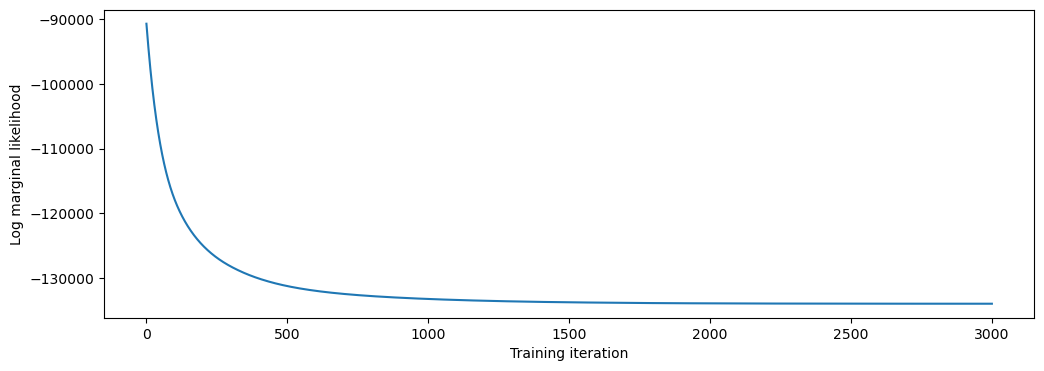

In [25]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_ )
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

## Sample from conditional GP

In [26]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.

# jibancat: Cosmological parameters in this case is in dim of 
# (n_examples, 5 features)

# predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# # Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
# predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Test input cosmologies
predictive_index_points_ = X_test

optimized_se_kernel = tfk.ExponentiatedQuadratic(
    amplitude_var, #length_scale, # feature_ndims=ndim
)
optimized_kernel = InputScaledKernel(
    optimized_se_kernel, length_scales = length_scale_var)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=X,
    observations=Y,
    # observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)

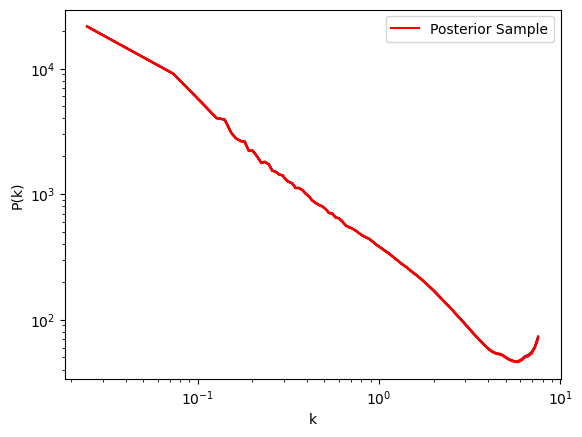

In [27]:
# plot the Pk comparison: GP predictions versus true Pk
test_i = 20

plt.loglog(10**kf, 10**(Y_test[:, test_i] + Y_mean))

for i in range(num_samples):
    plt.loglog(10**kf, 10**(samples[i, :, test_i] + Y_mean),
        c='r', alpha=.1,
        label='Posterior Sample' if i == 0 else None
    )

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"k")
plt.ylabel("P(k)")
plt.show()

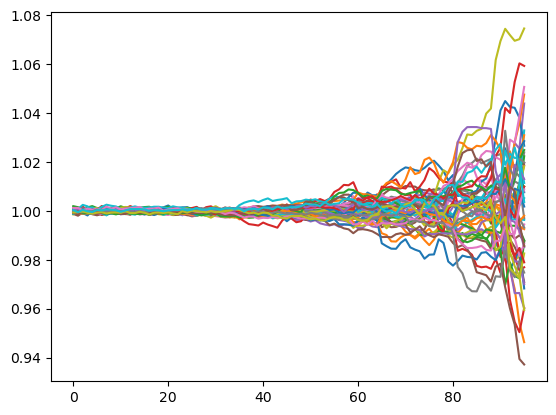

In [28]:
pred_exact = 10**(samples.numpy().mean(axis=0) + Y_mean[:, None]) / 10**(
    Y_test + Y_mean[:, None]
)
plt.plot(pred_exact);

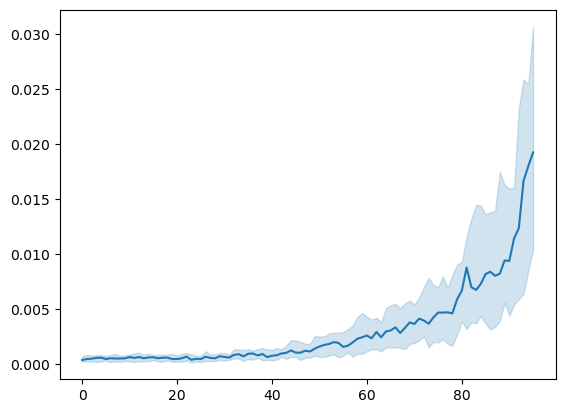

In [29]:
lower_error, median_error, upper_error = np.quantile(np.abs(pred_exact - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(median_error)
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error,
    y2=upper_error,
    color="C0",
    alpha=0.2
)

In [30]:
# sample from training points
gprm_train = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=X,
    observation_index_points=X,
    observations=Y,
    # observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples_train = gprm_train.sample(num_samples)

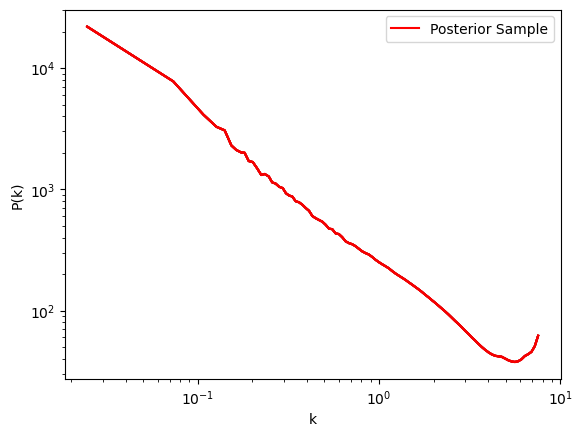

In [31]:
# plot the Pk comparison: GP predictions versus true Pk
train_i = 100

plt.loglog(10**kf, 10**(Y[:, train_i] + Y_mean))

for i in range(num_samples):
    plt.loglog(10**kf, 10**(samples_train[i, :, train_i] + Y_mean),
        c='r', alpha=.1,
        label='Posterior Sample' if i == 0 else None
    )

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"k")
plt.ylabel("P(k)")
plt.show()

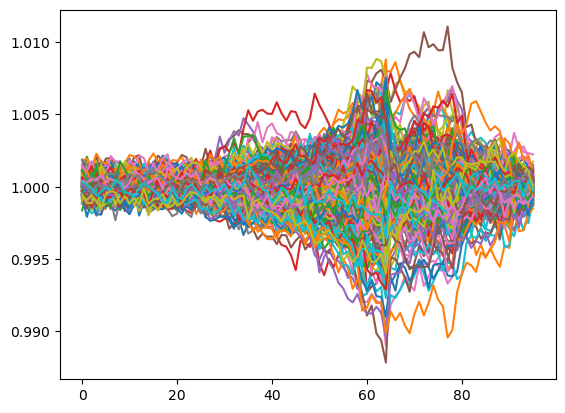

In [32]:
pred_exact_train = 10**(samples_train.numpy().mean(axis=0) + Y_mean[:, None]) / 10**(
    Y + Y_mean[:, None]
)
plt.plot(pred_exact_train);

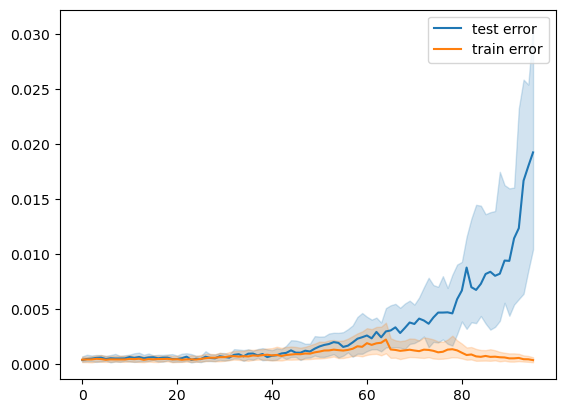

In [33]:
lower_error_train, median_error_train, upper_error_train = np.quantile(np.abs(pred_exact_train - 1), [0.25, 0.5, 0.75], axis=1)

plt.plot(median_error, label="test error")
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error,
    y2=upper_error,
    color="C0",
    alpha=0.2
)

plt.plot(median_error_train, color="C1", label="train error")
plt.fill_between(
    np.arange(pred_exact.shape[0]),
    y1=lower_error_train,
    y2=upper_error_train,
    color="C1",
    alpha=0.2
)

plt.legend()

## Marginalizing hyperparameters with HMC

Instead of optimizing the hyperparameters, let's try integrating them out with Hamiltonian Monte Carlo. We'll first define and run a sampler to approximately draw from the posterior distribution over kernel hyperparameters, given the observations.

In [36]:
amplitude_var

<TransformedVariable: name=amplitude, dtype=float64, shape=[96], fn="chain_of_shift_of_exp", numpy=
array([0.52777908, 0.75947735, 0.89400973, 0.85044226, 0.84400738,
       0.85434742, 0.91200987, 0.98007439, 1.00837093, 1.00159204,
       1.00446492, 0.97692692, 1.04671434, 1.06135284, 1.15359921,
       1.14466648, 1.11975707, 1.17138791, 1.20267907, 1.15026937,
       1.15236766, 1.18807773, 1.16933416, 1.14570548, 1.12816846,
       1.15605982, 1.18764426, 1.0606733 , 1.13655743, 1.14650511,
       1.11822342, 1.06711004, 0.99458458, 1.0760351 , 0.90112052,
       0.86420509, 0.8001071 , 0.73409028, 0.77497977, 0.79276264,
       0.7925871 , 0.826195  , 0.79541583, 0.76895376, 0.73550371,
       0.80001496, 0.90666043, 0.72957289, 0.7744234 , 0.52854862,
       0.54497316, 0.57324655, 0.60972711, 0.64732088, 0.58763772,
       0.47840028, 0.42842366, 0.40653188, 0.40582827, 0.33209806,
       0.55441089, 0.68996821, 0.67042148, 0.97082943, 0.77208837,
       0.25860055, 0.2391208 

In [34]:
tf.cast(0.1, tf.float64)

<tf.Tensor: shape=(), dtype=float64, numpy=0.10000000149011612>

In [39]:
num_results = 100
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64)),
    bijector=[constrain_positive, constrain_positive])

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

# initial values start with MAP estimation
initial_state = [
    amplitude_var,
    length_scale_var,
]

In [40]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results)

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 1827.34s.


Monte Carlo samples of hyperparameters

In [41]:
(amplitude_samples, length_scale_samples) = samples

In [45]:
amplitude_samples.shape

TensorShape([100, 96])

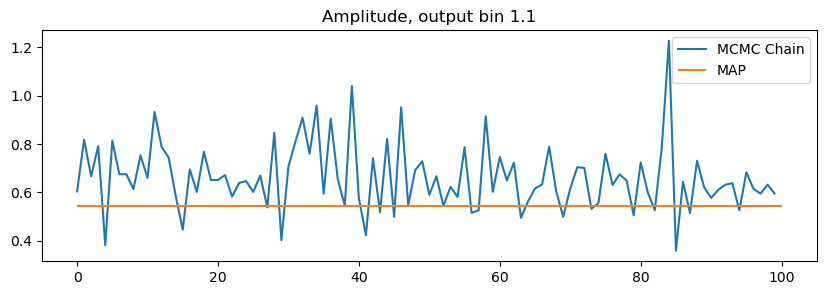

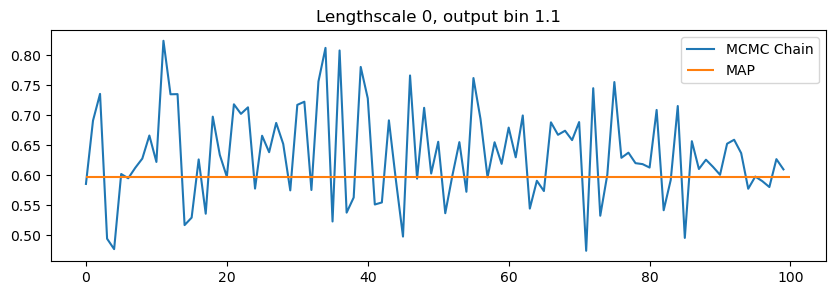

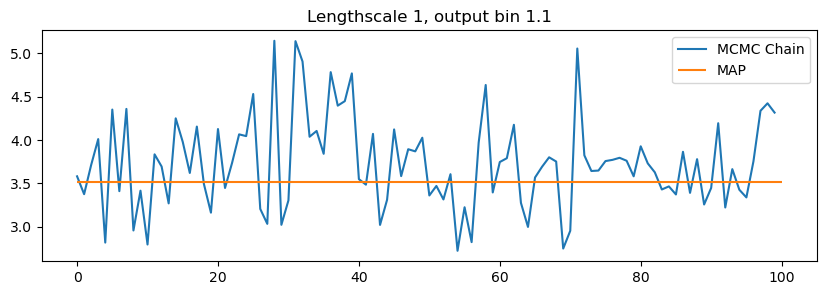

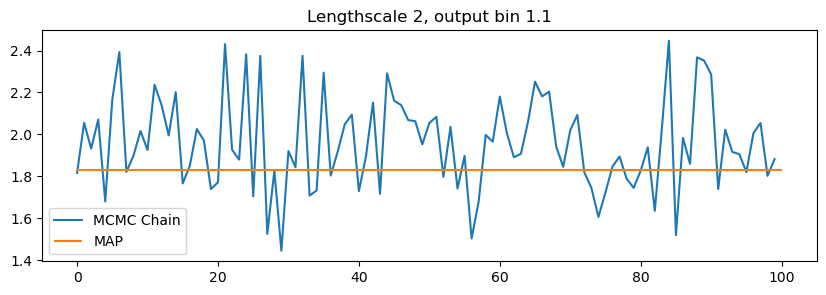

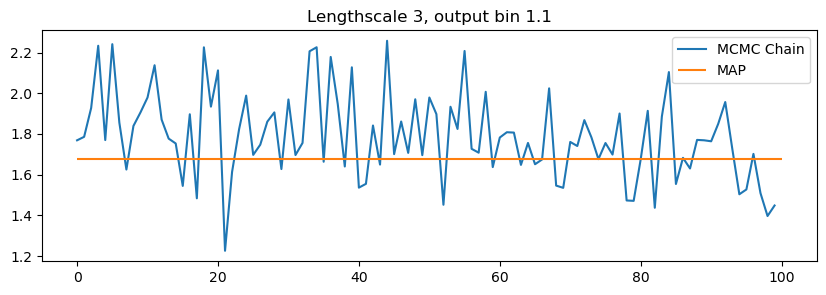

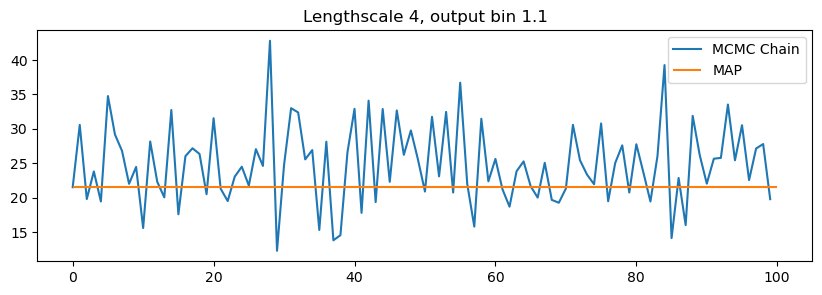

In [57]:
# check some of the chains
nth_output = 50

plt.figure(figsize=[10, 3])
plt.title("Amplitude, output bin {:.2g}".format(10**kf[nth_output]))
plt.plot(amplitude_samples[:, nth_output], label="MCMC Chain")
plt.hlines(amplitude_var[nth_output], 0, num_results, colors="C1", label="MAP")
plt.legend()
plt.show()

for i in range(num_features):
    plt.figure(figsize=[10, 3])
    plt.title("Lengthscale {}, output bin {:.2g}".format(
        i, 10**kf[nth_output])
    )
    plt.plot(length_scale_samples[:, nth_output, i], label="MCMC Chain")
    plt.hlines(length_scale_var[nth_output, i], 0, num_results, colors="C1", label="MAP")
    plt.legend()
    plt.show()

Jibancat: It seems like the samples are too few! But to sample more requires very long time. Probably better to put on a cluster to run the chains (or enable the GPU).

Now instead of constructing a single GP with the optimized hyperparameters, we construct the *posterior predictive distribution* as a mixture of GPs, each defined by a sample from the posterior distribution over hyperparameters. This approximately integrates over the posterior parameters via Monte Carlo sampling to compute the marginal predictive distribution at unobserved locations.